In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls "/content/drive/My Drive/Datasets"

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [0]:
import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
!pip install tensorflow==2.0.0-beta0


tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

In [0]:
"""
Unfortunately, CSV files have no built-in method of signalling character encoding.
read_csv defaults to guessing that the bytes in the CSV file represent text encoded in the UTF-8 encoding. 
This results in UnicodeDecodeError if the file is using some other encoding that results in bytes that don't happen to be a valid UTF-8 sequence. 
(If they by luck did also happen to be valid UTF-8, you wouldn't get the error, but you'd still get wrong input for non-ASCII characters, which would be worse really.)
It's up to you to specify what encoding is in play, which requires some knowledge (or guessing) of where it came from. 
For example if it came from MS Excel on a western install of Windows, it would probably be Windows code page 1252 and you could read it with:
"""


df=pd.read_csv("/content/drive/My Drive/Datasets/training.1600000.processed.noemoticon -Tweets.csv", encoding='cp1252')
df.columns = ['Label','Num','Time','Query','Tweet_id','Tweet']
df = df.drop(['Num','Time','Query'],axis=1)

df.head()
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 3 columns):
Label       1599999 non-null int64
Tweet_id    1599999 non-null object
Tweet       1599999 non-null object
dtypes: int64(1), object(2)
memory usage: 36.6+ MB
None


In [0]:
def processing(dataset):
  # Removing contents of tags and all for further text processing
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'<.+?>', value=r' ')
  
  # Removing @username
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'@[^\s]+', value=r' ')
  
  # Removing tickers
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'\$\w*', value=r' ') 
  
  # Removing #tags
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'#\w*', value=r' ')
  
  # Remove words with 2 or fewer letters
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'\b\w{1,2}\b', value=r' ')

  # Removing links from all for further text processing
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', value=r' ')

  # Replace email addresses
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'^.+@[^\.].*\.[a-z]{2,}$', value=r'')

  # Replace URLs with 'webaddress'
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', value=r'')

  # Replace 10 digit phone numbers
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', value=r'')

  # Replace numbers with 'numbr'
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'\d+(\.\d+)?', value=r'')

  # Remove punctuation
  dataset['Tweet'].replace(regex=True,inplace=True, to_replace= r'[^\w\d\s]', value=r'')

  #converting to lower case
  dataset['Tweet'] = dataset['Tweet'].str.lower()
  return dataset

In [0]:
df = processing(df)
df.head()

,Label,Tweet_id,Tweet
0,0,scotthamilton,upset that can update his facebook text...
1,0,mattycus,dived many times for the ball managed sa...
2,0,ElleCTF,whole body feels itchy and like its fire
3,0,Karoli,not behaving all mad why here ...
4,0,joy_wolf,not the whole crew


In [0]:
def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['Tweet'].apply(word_count)
df.head()

,Label,Tweet_id,Tweet,word count
0,0,scotthamilton,upset that can update his facebook text...,15
1,0,mattycus,dived many times for the ball managed sa...,12
2,0,ElleCTF,whole body feels itchy and like its fire,8
3,0,Karoli,not behaving all mad why here ...,13
4,0,joy_wolf,not the whole crew,4


In [0]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df["Label"] = label.fit_transform(df["Label"])
df.Label.unique()

array([0, 1])

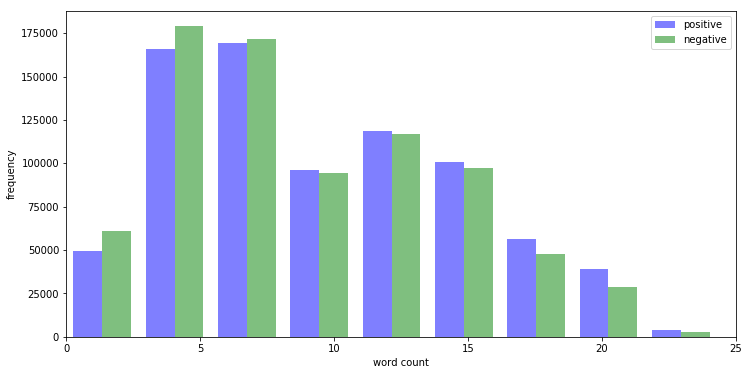

In [0]:
# plot word count distribution for both positive and negative sentiments
x = df['word count'][df.Label == 0]
y = df['word count'][df.Label == 1]
plt.figure(figsize=(12,6))
plt.xlim(0,25)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['b','g'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')


#Balanced Dataset

In [0]:
#Identify common words
freq = pd.Series(' '.join(df['Tweet']).split()).value_counts()[:20]
freq

the     520432
and     299062
you     297959
for     215777
that    163860
have    144649
but     128186
just    125246
with    114928
not     106658
was     104236
this     93255
can      92424
now      91083
good     89710
day      87428
all      82262
get      81702
out      81085
like     77888
dtype: int64

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


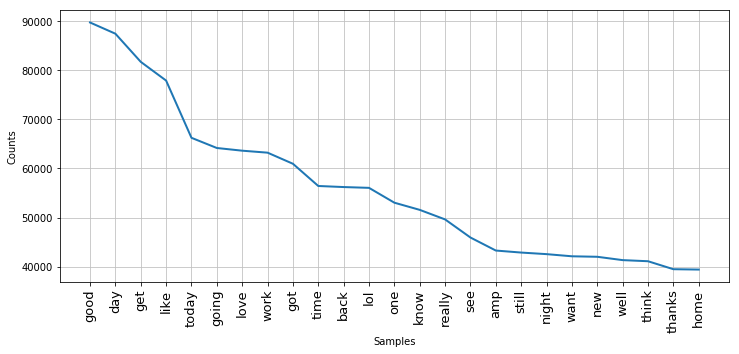

Text(0.5, 0, 'Word Rank')

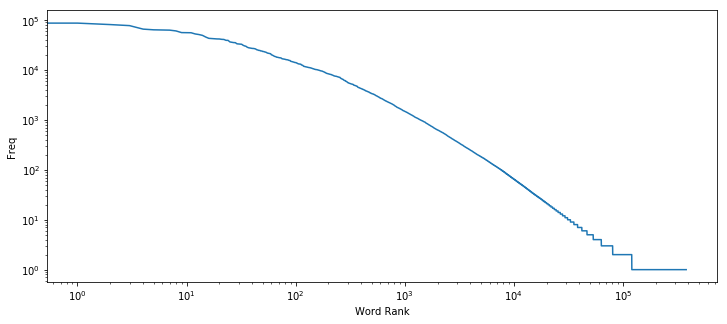

In [0]:
# most common words in twitter dataset
stop_words = set(stopwords.words("english"))
all_words = []
for line in list(df['Tweet']):
    words = line.split()
    for word in words:
      if word not in stop_words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

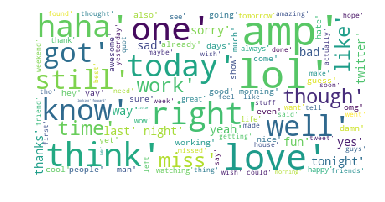

In [0]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(all_words))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1000)

In [0]:
vocab_size = 500
embedding_dim = 8
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Tweet'],df['Label'], test_size = 0.20, random_state=420)

In [0]:
print(len(x_train))

1279999


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

#print(train_sequences[0])
#print(train_padded[0])

#print(len(train_sequences[1]))
#print(len(train_padded[1]))


In [0]:
validation_sequences = tokenizer.texts_to_sequences(x_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

#print(len(validation_sequences))
#print(validation_padded.shape)

320000
(320000, 25)


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 8)             4000      
_________________________________________________________________
global_average_pooling1d_4 ( (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 150       
Total params: 4,366
Trainable params: 4,366
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 10
history = model.fit(train_padded,y_train , epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2)

Train on 1279999 samples, validate on 320000 samples
Epoch 1/10
1279999/1279999 - 184s - loss: 0.5293 - acc: 0.7320 - val_loss: 0.5127 - val_acc: 0.7395
Epoch 2/10
1279999/1279999 - 182s - loss: 0.5115 - acc: 0.7403 - val_loss: 0.5095 - val_acc: 0.7418
Epoch 3/10
1279999/1279999 - 183s - loss: 0.5096 - acc: 0.7417 - val_loss: 0.5131 - val_acc: 0.7386
Epoch 4/10
1279999/1279999 - 182s - loss: 0.5085 - acc: 0.7426 - val_loss: 0.5080 - val_acc: 0.7435
Epoch 5/10
1279999/1279999 - 183s - loss: 0.5076 - acc: 0.7433 - val_loss: 0.5078 - val_acc: 0.7435
Epoch 6/10
1279999/1279999 - 182s - loss: 0.5065 - acc: 0.7439 - val_loss: 0.5065 - val_acc: 0.7440
Epoch 7/10
1279999/1279999 - 182s - loss: 0.5052 - acc: 0.7449 - val_loss: 0.5057 - val_acc: 0.7447
Epoch 8/10
1279999/1279999 - 183s - loss: 0.5039 - acc: 0.7456 - val_loss: 0.5049 - val_acc: 0.7451
Epoch 9/10
1279999/1279999 - 183s - loss: 0.5028 - acc: 0.7464 - val_loss: 0.5035 - val_acc: 0.7456
Epoch 10/10
1279999/1279999 - 182s - loss: 0.50

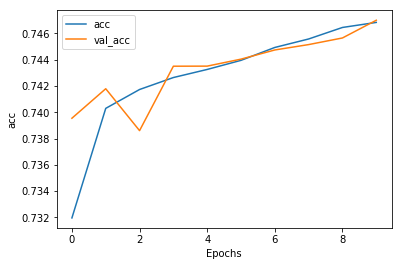

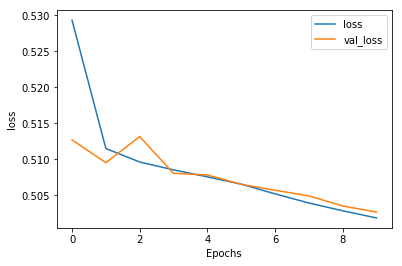

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")